<a href="https://colab.research.google.com/github/shwbak/Yolov7_StrongSORT_OSNet/blob/main/Forked_Models/PoseEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/project_pose

!unzip -qq "/content/drive/MyDrive/project_pose/Validation.zip"

/content/drive/MyDrive/project_pose
warning [/content/drive/MyDrive/project_pose/Validation.zip]:  46488181410 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/MyDrive/project_pose/Validation.zip]:  start of central directory not found;
  zipfile corrupt.
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
#!pip install moviepy
#pip install --upgrade torchvision

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import sys
import torch
import time
import datetime

from torchvision import transforms
from PIL import Image
from moviepy.editor import *

%matplotlib inline

In [ ]:
sys.version

'3.9.16 (main, Dec  7 2022, 01:11:51) \n[GCC 9.4.0]'

In [ ]:
!nvidia-smi

Wed Apr 12 05:11:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#1. Cloning YoloV7 repo


In [ ]:
YOLO_DIR = 'yolov7'

In [ ]:
if not os.path.exists(YOLO_DIR):
    print("Starting to clone the YoloV7 repo\n")
    !git clone https://github.com/WongKinYiu/yolov7.git
    print("\nDone")

if os.path.exists(YOLO_DIR):
    print("\nDirectory is present:\n")
    !ls yolov7

Starting to clone the YoloV7 repo

Cloning into 'yolov7'...
remote: Enumerating objects: 1139, done.
remote: Total 1139 (delta 0), reused 0 (delta 0), pack-reused 1139
Receiving objects: 100% (1139/1139), 70.41 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (488/488), done.
Updating files: 100% (104/104), done.

Done

Directory is present:

cfg	detect.py  hubconf.py  models	  requirements.txt  tools	  utils
data	export.py  inference   paper	  scripts	    train_aux.py
deploy	figure	   LICENSE.md  README.md  test.py	    train.py


In [ ]:
RESULTS_DIR = 'results'

if not os.path.exists(RESULTS_DIR):
    print("Creating the directory:", RESULTS_DIR)
    os.mkdir(RESULTS_DIR)
    print("Done")

Creating the directory: results
Done


#2.YoloV7 models


In [ ]:
YOLOV7_MODEL = [
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7x.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-d6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt",
]

In [ ]:
print("List of YoloV7 models:\n")
YOLOV7_MODEL

List of YoloV7 models:



['https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7x.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-d6.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt',
 'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt']

In [ ]:
def get_yolov7_model(modelistid=1):
    """
    Download YoloV7 model from a yoloV7 model list
    """
    modelid = YOLOV7_MODEL[modelistid]

    if not os.path.exists(modelid):
        print("Downloading the model:",
              os.path.basename(modelid), "from:", modelid)
        urllib.request.urlretrieve(modelid, 
                                   filename=os.path.basename(modelid))
        print("Done\n")
        !ls yolo*.pt -lh

    if os.path.exists(modelid):
        print("Downloaded model files:")
        !ls yolo*.pt -lh

# 3. Using YoloV7 models on images

In [ ]:
os.chdir(YOLO_DIR)

In [ ]:
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def image_view(imagefile, w=302, h=170):
    """
    Displaying an image from an image file
    """
    %matplotlib inline
    plt.figure(figsize=(w, h))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(cv2.imread(imagefile), 
                            cv2.COLOR_BGR2RGB))

In [ ]:
def loading_yolov7_model(yolomodel):
    """
    Loading yolov7 model
    """
    print("Loading model:", yolomodel)
    model = torch.load(yolomodel, map_location=device)['model']
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)

    return model, yolomodel

In [ ]:
def running_inference(image):
    """
    Running yolov7 model inference
    """
    image = letterbox(image, 960, 
                      stride=64,
                      auto=True)[0]  # shape: (567, 960, 3)
    image = transforms.ToTensor()(image)  # torch.Size([3, 567, 960])

    if torch.cuda.is_available():
        image = image.half().to(device)

    image = image.unsqueeze(0)  # torch.Size([1, 3, 567, 960])

    with torch.no_grad():
        output, _ = model(image)

    return output, image

In [ ]:
def draw_keypoints(output, image, confidence=0.25, threshold=0.65):
    """
    Draw YoloV7 pose keypoints
    """
    output = non_max_suppression_kpt(
        output,
        confidence,  # Confidence Threshold
        threshold,  # IoU Threshold
        nc=model.yaml['nc'],  # Number of Classes
        nkpt=model.yaml['nkpt'],  # Number of Keypoints
        kpt_label=True)

    with torch.no_grad():
        output = output_to_keypoint(output)

    nimg = image[0].permute(1, 2, 0) * 255
    nimg = cv2.cvtColor(nimg.cpu().numpy().astype(np.uint8), cv2.COLOR_RGB2BGR)

    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
        print(len(output[idx, :].T))
        print(output[idx, :].T)


    return nimg

##3.1. Using the tiny YoloV7 model

In [ ]:
YOLOV7_MODEL[0]

'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt'

In [ ]:
get_yolov7_model(0)

Done

-rw------- 1 root root  13M Apr 17 06:03 yolov7-tiny.pt
-rw------- 1 root root 154M Apr 17 06:02 yolov7-w6-pose.pt


In [ ]:
YOLOV7MODEL = os.path.basename(YOLOV7_MODEL[0])

try:
    print("Loading the model...")
    model, yolomodel = loading_yolov7_model(yolomodel=YOLOV7MODEL)
    print("Using the", YOLOV7MODEL, "model")
    print("Done")

except:
    print("[Error] Cannot load the model", YOLOV7MODEL)

Loading the model...
Loading model: yolov7-tiny.pt
Using the yolov7-tiny.pt model
Done


In [ ]:
# from PIL import Image
 
# image1 = Image.open("/content/drive/MyDrive/project_pose/images/test_bus.jpg")

# image1.show()

# imag1_size = image1.size

# print(imag1_size)

In [ ]:
image_view("/content/drive/MyDrive/project_pose/images/test_bus.jpg")

In [ ]:
!python detect.py --weights ./yolov7-tiny.pt --conf 0.2 --img-size 302 --source /content/drive/MyDrive/project_pose/images/test_bus.jpg

Namespace(weights=['./yolov7-tiny.pt'], source='/content/drive/MyDrive/project_pose/images/test_bus.jpg', img_size=302, conf_thres=0.2, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-122-g3b41c2c torch 2.0.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
Model Summary: 200 layers, 6219709 parameters, 229245 gradients
 Convert model to Traced-model... 
Traceback (most recent call last):
  File "/content/drive/MyDrive/project_pose/yolov7/detect.py", line 196, in <module>
    detect()
  File "/content/drive/MyDrive/project_pose/yolov7/detect.py", line 39, in detect
    model = TracedModel(model, device, opt.img_size)
  File "/content/drive/MyDrive/project_pose/yolov7/utils/torch_utils.py", line 362, in __init__
    traced_script_module = torch.jit.trace(self.model, rand_example, strict=False)
  F

In [ ]:
image_view("/content/drive/MyDrive/project_pose/images/test_bus.jpg")

##3.2. Using the yolov7-w6-pose model

In [ ]:
YOLOV7_MODEL[7]

'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt'

In [ ]:
get_yolov7_model(7)

Done

-rw------- 1 root root  13M Apr 17 06:03 yolov7-tiny.pt
-rw------- 1 root root 154M Apr 17 06:04 yolov7-w6-pose.pt


In [ ]:
YOLOV7MODEL = os.path.basename(YOLOV7_MODEL[7])

try:
    print("Loading the model...")
    model, yolomodel = loading_yolov7_model(yolomodel=YOLOV7MODEL)
    print("Using the", YOLOV7MODEL, "model")
    print("Done")

except:
    print("[Error] Cannot load the model", YOLOV7MODEL)

Loading the model...
Loading model: yolov7-w6-pose.pt
Using the yolov7-w6-pose.pt model
Done


58
[0.00000000e+00 0.00000000e+00 7.30156250e+02 3.02203125e+02 1.26687500e+02 2.80250000e+02 9.22896385e-01 7.82000000e+02 2.07500000e+02 6.25000000e-01 7.86000000e+02 2.02500000e+02 1.92260742e-01 7.79000000e+02 2.01250000e+02 6.63085938e-01 7.84500000e+02 1.98250000e+02 3.97033691e-02 7.64500000e+02 1.95625000e+02 8.40332031e-01 7.75500000e+02 2.25375000e+02 9.64355469e-01 7.36000000e+02 2.17750000e+02 9.79003906e-01 7.72000000e+02 2.63000000e+02 9.13085938e-01 7.09000000e+02 2.51000000e+02 9.66308594e-01 7.69000000e+02 2.96750000e+02 9.00390625e-01 7.20500000e+02 2.87750000e+02 9.51660156e-01 7.52500000e+02 3.01250000e+02 9.82421875e-01 7.29000000e+02 2.98750000e+02 9.86328125e-01 7.30500000e+02 3.52250000e+02 9.66308594e-01 7.30000000e+02 3.61250000e+02 9.75097656e-01 6.84000000e+02 3.64000000e+02 9.28710938e-01 7.05000000e+02 4.14500000e+02 9.39453125e-01]


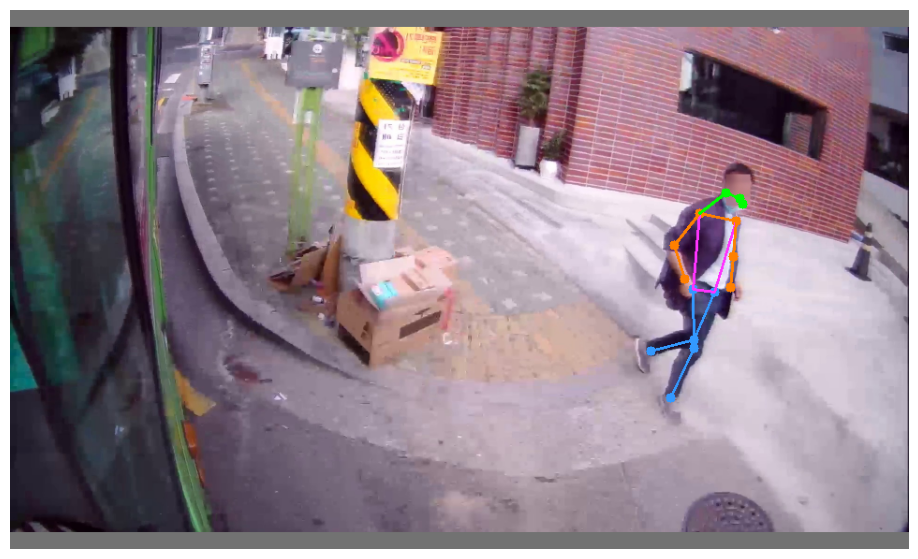

In [ ]:
imagefile = "/content/drive/MyDrive/project_pose/images/test_bus2.jpg"

output, image = running_inference(cv2.imread(imagefile))
pose_image = draw_keypoints(output, image, confidence=0.25, threshold=0.65)

plt.figure(figsize=(30, 7))
plt.axis("off")
plt.imshow(pose_image)

In [ ]:
print(running_inference(cv2.imread(imagefile)))

(tensor([[[ 5.39062e+00,  3.94141e+00,  1.38594e+01,  ..., -1.31445e+00,  3.37812e+01,  1.73950e-01],
         [ 1.11914e+01,  3.66797e+00,  2.13750e+01,  ...,  4.26562e+00,  2.91250e+01,  2.08862e-01],
         [ 1.88047e+01,  3.89062e+00,  2.45469e+01,  ...,  8.54688e+00,  2.42188e+01,  2.13989e-01],
         ...,
         [ 8.04875e+02,  5.11422e+02,  3.40750e+02,  ...,  7.75500e+02,  5.75500e+02,  2.83203e-01],
         [ 8.59500e+02,  5.04703e+02,  3.24000e+02,  ...,  8.34500e+02,  5.74000e+02,  2.77344e-01],
         [ 9.17062e+02,  5.10734e+02,  3.38500e+02,  ...,  8.74500e+02,  5.91500e+02,  2.68555e-01]]], device='cuda:0'), tensor([[[[0.44702, 0.44702, 0.44702,  ..., 0.44702, 0.44702, 0.44702],
          [0.44702, 0.44702, 0.44702,  ..., 0.44702, 0.44702, 0.44702],
          [0.44702, 0.44702, 0.44702,  ..., 0.44702, 0.44702, 0.44702],
          ...,
          [0.44702, 0.44702, 0.44702,  ..., 0.44702, 0.44702, 0.44702],
          [0.44702, 0.44702, 0.44702,  ..., 0.44702, 0.4

# 4. Analysing a video with yolov7-w6-pose

In [ ]:
def yoloV7_pose_video(videofile, confidence=0.25, threshold=0.65):
    """
    Processing the video using YoloV7
    """
    start = time.time()
    # Reading video
    video = VideoFileClip(videofile)

    # Stats
    duration = video.duration
    fps = round(video.fps)
    nbframes = round(duration * fps)

    print("Processing video:", videofile, "using confidence min =", confidence,
          "and threshold =", threshold)
    print("\nVideo duration =", duration, "seconds")
    print("FPS =", fps)
    print("Total number of frames =", nbframes, "\n")

    # Capture the results frames into a video
    capture = cv2.VideoCapture(videofile)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    outputvideofile = "../results/result_" + os.path.basename(videofile)
    outvideo = cv2.VideoWriter(outputvideofile, fourcc, 30.0,
                               (int(capture.get(3)), int(capture.get(4))))
    idx = 1

    while capture.isOpened():
        (ret, frame) = capture.read()

        if ret == True:
            if idx % fps == 1:
                nbremainframes = nbframes - idx
                pctdone = round(idx / nbframes * 100)
                print("Processed frames =", f"{idx:06}",
                      "| Number of remaining frames:", f"{nbremainframes:06}",
                      "| Done:", pctdone, "%")

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            output, frame = running_inference(frame)
            frame = draw_keypoints(output, frame, confidence, threshold)
            frame = cv2.resize(frame,
                               (int(capture.get(3)), int(capture.get(4))))

            cv2.imwrite(
                "results/videoframe_" + os.path.basename(videofile) + '_' +
                str(f"{idx:06}.jpg"), frame)
            outvideo.write(frame)  # output to video file

        else:
            break

        idx += 1

    processed_time = round(time.time() - start)
    time_per_frame = round(processed_time / (idx - 1), 2)
    print("\nDone in", processed_time, "seconds")
    print("Time per frame =", time_per_frame, "seconds")
    print("\nSaved video:", outputvideofile)

    capture.release()
    outvideo.release()

    return outputvideofile

##4.1. Test1

In [ ]:
!ls ../videos/football.mp4 -lh

In [ ]:
football_vid = "../videos/football.mp4"
football_video = yoloV7_pose_video(football_vid)

In [ ]:
VideoFileClip(football_video).ipython_display(width=640)

##4.2. Test2

In [ ]:
!ls ../videos/tennis.mp4 -lh

In [ ]:
tennis_vid = "../videos/tennis.mp4"
tennis_video = yoloV7_pose_video(tennis_vid)

In [ ]:
VideoFileClip(tennis_video).ipython_display(width=640)